### Import all necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
pd.set_option("display.max_rows", None, "display.max_columns", None)

### Load samples from csv files

In [2]:
sample1 = pd.read_csv('lem_pos_first.csv')
sample2 = pd.read_csv('lem_pos_second.csv')

In [ ]:
sample1.head()

,word_form_id,word_form,lemma,pos,sent_id,text_numb
0,1,ярослав,ярослав,NOUN,1,1
1,2,грицак,грицак,NOUN,1,1
2,3,нариси,нарис,NOUN,2,1
3,4,з,з,PREP,2,1
4,5,історії,історія,NOUN,2,1


In [ ]:
sample2.head()

,word_form_id,word_form,lemma,pos,sent_id,text_numb
0,1,веселий,веселий,ADJF,1,1
1,2,цвинтар,цвинтар,NOUN,1,1
2,3,над,над,PREP,2,1
3,4,осіннім,осінній,ADJF,2,1
4,5,озером,озеро,NOUN,2,1


### Build frequency dictionaries based on samples

In [3]:
def create_frequency_dictionaries(dataframe):
    """
    Create frequency dictionaries for specified fields in the given dataframe.

    Parameters:
    dataframe (pandas.DataFrame): The input dataframe containing relevant data.

    Returns:
    list of pandas.Series: A list of frequency dictionaries for each specified field.
                           Each dictionary contains field values as keys and their respective
                           frequencies as values, sorted in descending order.
    """
    fields = ['lemma', 'word_form', 'pos']
    fd_dicts = []
    for field in fields:
        fd_dicts.append(dataframe.groupby(field, sort=True)[field].count().sort_values(ascending=False))
    return fd_dicts

In [4]:
fd_lemma1, fd_wordform1, fd_pos1 = create_frequency_dictionaries(sample1)

In [5]:
fd_lemma2, fd_wordform2, fd_pos2 = create_frequency_dictionaries(sample2)

### Build frequency dictionaries based on subsamples

In [6]:
def divide_into_subsamples(dataframe):
  """
  Divide a data into 20 approximately equal-sized subsamples.

  Parameters:
  dataframe (pandas.DataFrame): The input DataFrame to be divided.

  Returns:
  list of pandas.DataFrame: A list containing 20 subsamples of the input DataFrame.
  """
  # randomly distribute data, ensuring reproducibility of results
  shuffled = dataframe.sample(frac=1, random_state = np.random.RandomState(2))
  # divide the data into 20 subsamples of 1000 word forms each
  return np.array_split(shuffled, 20)

In [7]:
def fd_subsample(subsamples):
    """
    Calculate frequency dictionaries for lemma, word form, and part-of-speech (POS)
    based on a list of subsamples.

    Parameters:
    subsamples (list of pandas.DataFrame): A list containing 20 subsamples of data.

    Returns:
    tuple: A tuple containing three lists of frequency dictionaries - one for lemma,
           one for word form, and one for part-of-speech (POS).
    """
    fd_lemma = []
    fd_wordform = []
    fd_pos = []

    for i in range(20):
        fd_lemma.append(pd.DataFrame(subsamples[i]).groupby('lemma', sort=True)['lemma'].count().sort_values(ascending=False).to_dict())
        fd_wordform.append(pd.DataFrame(subsamples[i]).groupby('word_form', sort=True)['word_form'].count().sort_values(ascending=False).to_dict())
        fd_pos.append(pd.DataFrame(subsamples[i]).groupby('pos', sort=True)['pos'].count().sort_values(ascending=False).to_dict())

    return fd_lemma, fd_wordform, fd_pos

In [8]:
subsamples_1 = divide_into_subsamples(sample1)
fd_lemmas1, fd_wordforms1, fd_poses1 = fd_subsample(subsamples_1)

In [9]:
subsamples_2 = divide_into_subsamples(sample2)
fd_lemmas2, fd_wordforms2, fd_poses2 = fd_subsample(subsamples_2)

In [10]:
def abs_freq_dist(subsamples, column, search_option, sample=0, plot=False):
    """
    Calculate absolute frequency distribution and grouped frequencies by variants for a specified column and search option in each subsample.

    Parameters:
    subsamples (list of pandas.DataFrame): A list of subsamples containing data.
    column (str): The column to search for the specified option (lemma, word_form, pos).
    search_option (str): The option to search for in the specified column (POS tag, wordform, lemma).
    plot (bool, optional): Whether to plot the distribution. Default is False.
    sample (int, optional): The sample number (1 or 2). Default is 0.

    Returns:
    tuple of pandas.DataFrame: A tuple containing two dataframes.
        The first dataframe contains absolute frequency distribution for each subsample.
        The second dataframe contains grouped frequencies by absolute values.
    """

    absolute_frequencies = []

    for sub_sample in subsamples:
        absolute_frequencies.append(sub_sample[sub_sample[column] == search_option].shape[0])

    abs_f = pd.DataFrame(absolute_frequencies, columns=['Xi'])
    abs_f.index += 1

    grouped = abs_f.groupby('Xi')['Xi'].count().reset_index(name="Ni")
    grouped.index += 1

    if plot:
        vis = grouped.plot(x='Xi', y='Ni', title=f"A polygon for the word {search_option.upper()} in the sample №{sample} by the variation series")
        vis.set_xlabel("Xi variant")
        vis.set_ylabel("Ni variant frequency")
        vis.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
        vis.fill_between(grouped['Xi'], grouped['Ni'])
    else:
        return abs_f, grouped

In [11]:
def rel_freq_dist(subsamples, column, search_option):
    """
    Calculate average relative frequency.

    Parameters:
    subsamples (list of pandas.DataFrame): A list of subsamples containing data.
    column (str): The column to search for the specified option (lemma, word_form, pos).
    search_option (str): The option to search for in the specified column (POS tag, wordform, lemma).

    Returns:
    float: The average relative frequency for the specified option.
    """
    absolute_frequencies = []

    for sub_sample in subsamples:
        absolute_frequencies.append(sub_sample[sub_sample[column] == search_option].shape[0])

    relative_frequencies = list(np.array(absolute_frequencies[:]) / 1000)

    abs_f = pd.DataFrame(relative_frequencies, columns=['Pi'])
    abs_f.index += 1
    abs_f.index.name = 'sample number'

    grouped = abs_f.groupby('Pi')['Pi'].count().reset_index(name="Ni")
    grouped['PiNi'] = grouped['Pi'] * grouped['Ni']

    return grouped['PiNi'].sum() / grouped['Ni'].sum()

In [12]:
def count_prestats(subsamples, frequency_dictionary, column, search_option):
    """Calculates pre-statistics needed for mean squared error.

    Parameters
    subsamples (list of pandas.DataFrame): A list of subsamples containing data.
    frequency_dictionary (pandas.core.series.Series): a frequency dictionary created based on sample.
    column (str): The column to search for the specified option (lemma, word_form, pos).
    search_option: The option to search for in the specified column (POS tag, wordform, lemma).
    """
    _, grouped_abs = abs_freq_dist(subsamples, column, search_option)

    pre_stats = grouped_abs

    pre_stats['XiNi'] = pre_stats['Xi'] * pre_stats['Ni']

    last_column = pre_stats.sum().to_dict()

    pre_stats.loc[len(pre_stats.index) + 1] = [f"Σ = {last_column['Xi']}", f"Σ = {last_column['Ni']}", f"Σ = {last_column['XiNi']}"]

    pre_stats['x̄'] = [last_column['XiNi'] / last_column['Ni']]+['']*(len(pre_stats)-1)

    pre_stats['Xi - x̄'] = pre_stats['Xi'][:-1] - pre_stats['x̄'][1]

    pre_stats['(Xi - x̄)²'] = pre_stats['Xi - x̄'][:-1] * pre_stats['Xi - x̄'][:-1]

    pre_stats['(Xi - x̄)²Ni'] = pre_stats['(Xi - x̄)²'][:-1] * pre_stats['Ni'][:-1]

    pre_stats.insert(loc = 0, column = 'm', value = [frequency_dictionary[search_option]]+['']*(len(pre_stats)-1))

    pre_stats.insert(loc = 1, column = 'p', value = [frequency_dictionary[search_option]/20000]+['']*(len(pre_stats)-1))

    pre_stats.insert(loc = 2, column = 'p-bar', value = [rel_freq_dist(subsamples, column, search_option)]+['']*(len(pre_stats)-1))

    return pre_stats

In [13]:
def other_statistics(prestats):
    """Calculates
                  standard deviation
                  confidence interval 2σ
                  measure of fluctuation of the average frequency
                  confidence interval 2σх̅
                  coefficient of variation
                  maximum coefficient of variation
                  stability coefficient
                  relative error of the study

    Parameters
    prestats (pandas.core.frame.DataFrame): dataframe containing prestatistics (absolute frequency, average frequency, relative frequency, average relative frequency, (Xi - x̄)²Ni, Ni).
    """
    prestats['σ'] = [math.sqrt(prestats["(Xi - x̄)²Ni"].sum() / prestats["Ni"][:-1].sum())]+['']*(len(prestats)-1)
    prestats['x̄ - 2σ'] = [prestats['x̄'][1] - 2*prestats['σ'][1]]+['']*(len(prestats)-1)
    prestats['x̄ + 2σ'] = [prestats['x̄'][1] + 2*prestats['σ'][1]]+['']*(len(prestats)-1)
    prestats['σx̄'] = [prestats['σ'][1] / math.sqrt(prestats["Ni"][:-1].sum())]+['']*(len(prestats)-1)
    prestats['x̄ - 2σx̄'] = [prestats['x̄'][1] - 2*prestats['σx̄'][1]]+['']*(len(prestats)-1)
    prestats['x̄ + 2σx̄'] = [prestats['x̄'][1] + 2*prestats['σx̄'][1]]+['']*(len(prestats)-1)
    prestats['v'] = [prestats['σ'][1] / prestats['x̄'][1]]+['']*(len(prestats)-1)
    prestats['Vmax'] = [math.sqrt(prestats["Ni"][:-1].sum() - 1)]+['']*(len(prestats)-1)
    prestats['D'] = [1 - (prestats['v'][1] / prestats['Vmax'][1])]+['']*(len(prestats)-1)
    prestats['E'] = [(1.96 /math.sqrt(prestats["Ni"][:-1].sum())*prestats['v'][1])]+['']*(len(prestats)-1)
    return prestats

## How to calculate statistics

In [ ]:
# subsamples_1, subsamples_2
# fd_wordform1, fd_wordform2 - fd_lemma1, fd_lemma2 - fd_pos1, fd_pos2
# word_form, lemma, pos
# землі, земля, NOUN

In [14]:
other_statistics(count_prestats(subsamples_1, fd_wordform1, 'word_form', 'землі'))

,m,p,p-bar,Xi,Ni,XiNi,x̄,Xi - x̄,(Xi - x̄)²,(Xi - x̄)²Ni,σ,x̄ - 2σ,x̄ + 2σ,σx̄,x̄ - 2σx̄,x̄ + 2σx̄,v,Vmax,D,E
1,28,0.0014,0.0014,0,7,0,1.4,-1.4,1.96,13.72,1.496663,-1.593326,4.393326,0.334664,0.730672,2.069328,1.069045,4.358899,0.754744,0.46853
2,,,,1,5,5,,-0.4,0.16,0.8,,,,,,,,,,
3,,,,2,4,8,,0.6,0.36,1.44,,,,,,,,,,
4,,,,3,3,9,,1.6,2.56,7.68,,,,,,,,,,
5,,,,6,1,6,,4.6,21.16,21.16,,,,,,,,,,
6,,,,Σ = 12,Σ = 20,Σ = 28,,NaN,NaN,NaN,,,,,,,,,,


In [15]:
other_statistics(count_prestats(subsamples_1, fd_lemma1, 'lemma', 'земля'))

,m,p,p-bar,Xi,Ni,XiNi,x̄,Xi - x̄,(Xi - x̄)²,(Xi - x̄)²Ni,σ,x̄ - 2σ,x̄ + 2σ,σx̄,x̄ - 2σx̄,x̄ + 2σx̄,v,Vmax,D,E
1,73,0.00365,0.00365,0,1,0,3.65,-3.65,13.3225,13.3225,1.981792,-0.313584,7.613584,0.443142,2.763716,4.536284,0.542957,4.358899,0.875437,0.237961
2,,,,1,1,1,,-2.65,7.0225,7.0225,,,,,,,,,,
3,,,,2,4,8,,-1.65,2.7225,10.89,,,,,,,,,,
4,,,,3,5,15,,-0.65,0.4225,2.1125,,,,,,,,,,
5,,,,4,3,12,,0.35,0.1225,0.3675,,,,,,,,,,
6,,,,5,2,10,,1.35,1.8225,3.645,,,,,,,,,,
7,,,,6,2,12,,2.35,5.5225,11.045,,,,,,,,,,
8,,,,7,1,7,,3.35,11.2225,11.2225,,,,,,,,,,
9,,,,8,1,8,,4.35,18.9225,18.9225,,,,,,,,,,
10,,,,Σ = 36,Σ = 20,Σ = 73,,NaN,NaN,NaN,,,,,,,,,,


In [16]:
other_statistics(count_prestats(subsamples_1, fd_pos1, 'pos', 'NOUN'))

,m,p,p-bar,Xi,Ni,XiNi,x̄,Xi - x̄,(Xi - x̄)²,(Xi - x̄)²Ni,σ,x̄ - 2σ,x̄ + 2σ,σx̄,x̄ - 2σx̄,x̄ + 2σx̄,v,Vmax,D,E
1,7350,0.3675,0.3675,334,1,334,367.5,-33.5,1122.25,1122.25,16.716758,334.066484,400.933516,3.737981,360.024039,374.975961,0.045488,4.358899,0.989564,0.019936
2,,,,342,1,342,,-25.5,650.25,650.25,,,,,,,,,,
3,,,,348,1,348,,-19.5,380.25,380.25,,,,,,,,,,
4,,,,354,1,354,,-13.5,182.25,182.25,,,,,,,,,,
5,,,,357,1,357,,-10.5,110.25,110.25,,,,,,,,,,
6,,,,361,1,361,,-6.5,42.25,42.25,,,,,,,,,,
7,,,,363,2,726,,-4.5,20.25,40.5,,,,,,,,,,
8,,,,364,2,728,,-3.5,12.25,24.5,,,,,,,,,,
9,,,,366,1,366,,-1.5,2.25,2.25,,,,,,,,,,
10,,,,368,1,368,,0.5,0.25,0.25,,,,,,,,,,


## testing null hypothesis

In [17]:
def plot_frequency_poligon(a1, b1, c1, d1, a2, b2, c2, d2, option):
    """
    Plot a frequency polygon representing confidence intervals for two samples.

    Parameters:
    a1 (float): Lower boundary of the 68% confidence interval for sample 1.
    b1 (float): Upper boundary of the 68% confidence interval for sample 1.
    c1 (float): Lower boundary of the 95% confidence interval for sample 1.
    d1 (float): Upper boundary of the 95% confidence interval for sample 1.
    a2 (float): Lower boundary of the 68% confidence interval for sample 2.
    b2 (float): Upper boundary of the 68% confidence interval for sample 2.
    c2 (float): Lower boundary of the 95% confidence interval for sample 2.
    d2 (float): Upper boundary of the 95% confidence interval for sample 2.
    option (str): The option being visualized (lemma, wordform, POS tag).

    Returns:
    None
    """
    plt.figure(figsize=(10, 5))
    plt.hlines(y=0.5, xmin=a1, xmax=b1, colors='black', linestyles='-', lw=2, label='68% - sample 1')
    plt.vlines(a1, 0, 0.5, linestyles ="dotted", colors ="k")
    plt.vlines(b1, 0, 0.5, linestyles ="dotted", colors ="k")
    plt.hlines(y=1, xmin=c1, xmax=d1, colors='red', linestyles='-', lw=2, label='95% - sample 1')
    plt.vlines(c1, 0, 1, linestyles ="dotted", colors ="k")
    plt.vlines(d1, 0, 1, linestyles ="dotted", colors ="k")
    plt.hlines(y=0.5, xmin=a2, xmax=b2, colors='yellow', linestyles='-', lw=2, label='68% - sample 2')
    plt.vlines(a2, 0, 0.5, linestyles ="dotted", colors ="k")
    plt.vlines(b2, 0, 0.5, linestyles ="dotted", colors ="k")
    plt.hlines(y=1, xmin=c2, xmax=d2, colors='blue', linestyles='-', lw=2, label='95% - sample 2')
    plt.vlines(c2, 0, 1, linestyles ="dotted", colors ="k")
    plt.vlines(d2, 0, 1, linestyles ="dotted", colors ="k")
    plt.title('Average frequency fluctation bandwidth for ' + option + ' for confidence intervals x̄ + $σ_{x̄}$ and x̄ + 2$σ_{x̄}$')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=5)
    plt.show()

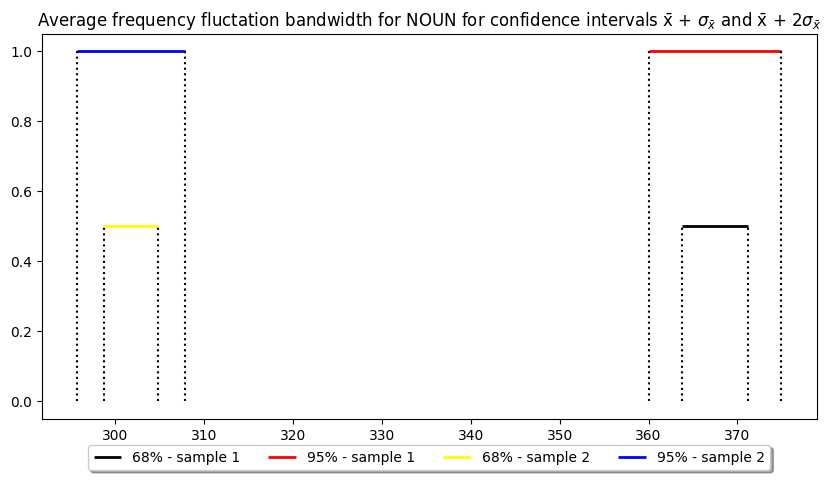

In [18]:
plot_frequency_poligon(363.77, 371.23, 360.04, 374.96, 298.71, 304.79, 295.67, 307.83, 'NOUN')

**CONCLUSION**: Let's assume that there are no significant statistical differences between the fluctuations in the mean frequency of the NOUN and we can combine our samples into one general population (null hypothesis). We can see that our bands of fluctuations in the mean frequency of the NOUN do not overlap in any of the intervals. Therefore, we cannot combine our samples, so we reject the null hypothesis.

## Polygons for absolute frequencies and interval distribution of absolute frequencies

In [19]:
def match_variants_with_intervals(intervals, variant_occurrences):
    """
    Match variant occurrences with predefined intervals and count occurrences within each interval.

    Parameters:
    intervals (list of tuples): List of tuples representing intervals.
    variant_occurrences (list of tuples): List of tuples where each tuple contains a variant value and its occurrences.

    Returns:
    list of tuples: List of tuples where each tuple contains an interval and the count of occurrences within that interval.
    """
    results = []

    for interval in intervals:
        interval_start, interval_end = interval
        occurrences_within_interval = 0

        for variant, occurrences in variant_occurrences:
            if interval_start <= variant < interval_end:
                occurrences_within_interval += occurrences

        results.append((interval, occurrences_within_interval))

    return results


def calculate_middle_values(lst):
    """
    Calculate middle values of intervals from a list of interval-occurrence tuples.

    Parameters:
    lst (list of tuples): List of tuples where each tuple contains an interval and a value (occurrences).

    Returns:
    list: List of middle values for each interval.
    """
    middle_values = []
    for interval, _ in lst:
        start, end = interval
        middle = (start + end) / 2
        middle_values.append(middle)
    return middle_values


def extract_third_values(lst):
    """
    Extract the third values (occurrences) from a list of interval-occurrence tuples.

    Parameters:
    lst (list of tuples): List of tuples where each tuple contains an interval and a value (occurrences).

    Returns:
    list: List of third values (occurrences) for each interval.
    """
    third_values = []
    for _, value in lst:
        third_values.append(value)
    return third_values


def calculate_intervals(lst, token, sample):
    """
    Calculate intervals and visualize data.

    Parameters:
    lst (pandas Series): Pandas Series containing data (values and occurrences) to be analyzed.
    token (str): String indicating the token being analyzed.
    sample (int): Integer indicating the sample number.

    Returns:
    None
    """
    lst = lst.values.tolist()
    # Calculate the difference between smallest and largest values
    smallest = lst[0][0]
    largest = lst[-1][0]
    R = largest - smallest

    # Find the uneven number H
    H = 1
    while R // H > 2:
        H += 1
    if H % 2 == 0:
        H = H - 1
    # Construct intervals and count values within each interval
    interval_start = smallest
    interval_count = 0
    intervals = []
    interval_length = R / H
    for nested_list in lst:
        value, count = nested_list
        if value >= interval_start and value < interval_start + interval_length:
            interval_count += count
        else:
            intervals.append((round(interval_start,1), round(interval_start + interval_length, 1)))
            interval_start += interval_length
            interval_count = count
            if interval_start == largest:
                break

    result = match_variants_with_intervals(intervals, lst)
    middles = calculate_middle_values(result)
    thirds = extract_third_values(result)

    df = pd.DataFrame({'Xi': middles, 'Ni': thirds})

    vis = df.plot(x='Xi', y='Ni', title=f"Interval series of absolute frequencies {token.upper()} of the sample №{sample}")
    vis.set_xlabel("Xi variant")
    vis.set_ylabel("Ni variant frequency")
    vis.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    vis.fill_between(df['Xi'], df['Ni'])

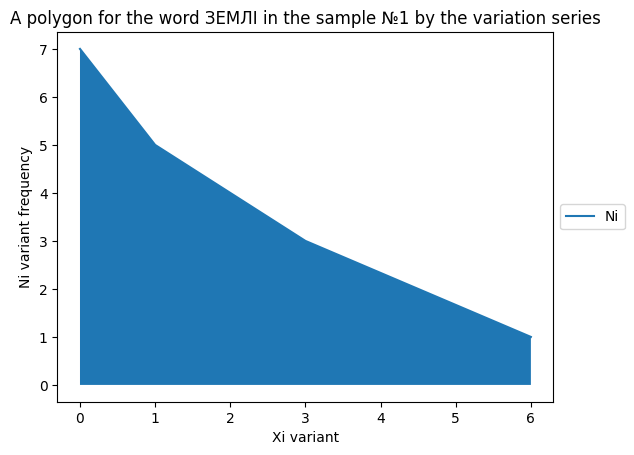

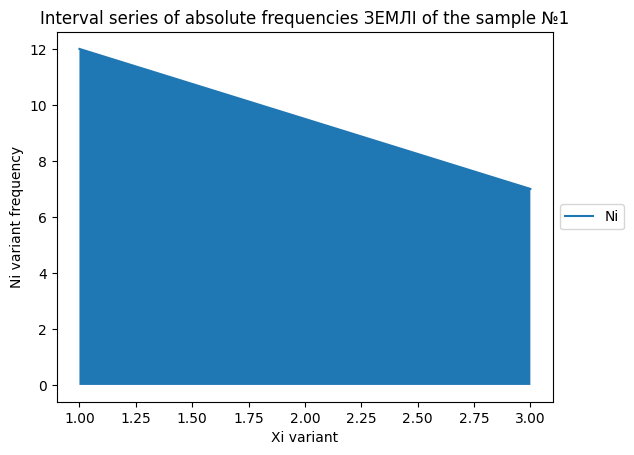

In [20]:
abs_freq_dist(subsamples_1, 'word_form', 'землі', 1, plot=True)
calculate_intervals(abs_freq_dist(subsamples_1, 'word_form', 'землі')[1], "землі", 1)

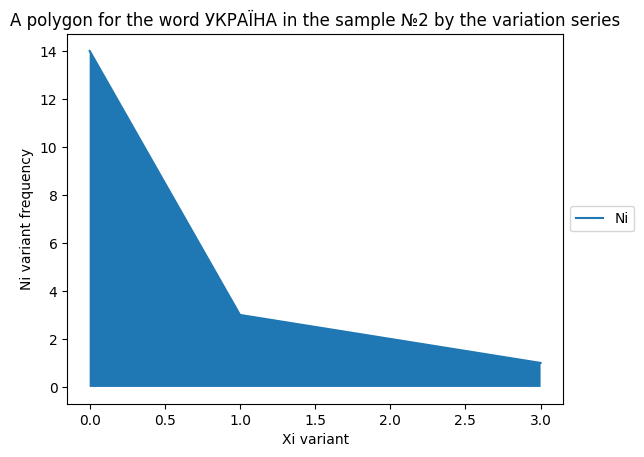

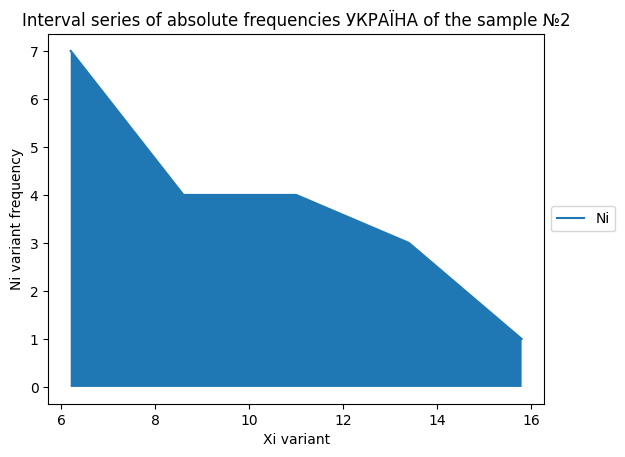

In [21]:
abs_freq_dist(subsamples_2, 'lemma', 'україна', 2, plot=True)
calculate_intervals(abs_freq_dist(subsamples_1, 'lemma', 'україна')[1], "україна", 2)

## Calculate χ²

In [22]:
def calculate_Xi_2():
    """
    Calculate Chi-square values for different parts of speech across two subsamples.

    Returns:
    list: List of Chi-square values for different parts of speech.
    """
    # List of parts of speech tags
    pos_keys = ['NOUN', 'VERB', 'CONJ', 'ADJF', 'NPRO', 'PREP', 'PRCL', 'ADVB', 'GRND', 'NUMR', 'INTJ', 'PRED']
    results = []

    # Dictionary to store occurrences for each part of speech in 'M1' and 'M2' subsamples
    χ_values = {pos: {f'M1': [], f'M2': []} for pos in pos_keys}

    # Gather occurrences for each part of speech in 'M1' subsample
    for subsample in fd_poses1:
        for pos in pos_keys:
            χ_values[pos]['M1'].append(subsample.get(pos, 0))

    # Gather occurrences for each part of speech in 'M2' subsample
    for subsample in fd_poses2:
        for pos in pos_keys:
            χ_values[pos]['M2'].append(subsample.get(pos, 0))

    # Calculate Chi-square values for each part of speech
    for pos in pos_keys:
        df = pd.DataFrame(χ_values[pos]).T
        df.columns = ['K1', 'K2', 'K3', 'K4', 'K5', 'K6', 'K7', 'K8', 'K9', 'K10', 'K11', 'K12', 'K13', 'K14', 'K15', 'K16', 'K17', 'K18', 'K19', 'K20']
        df.loc['ΣK'] = df.sum(axis=0)
        df['ΣM'] = df.sum(axis=1)
        results.append(count_χ(df, pos))

    return results

In [23]:
def count_χ(dataframe, pos):
    """
    Calculates chi-squared based on the dataframe.

    Parameters:
    dataframe (pandas.core.frame.DataFrame): dataframe with M1, M2, ΣK rows and K1-K20, ΣM columns.
    pos (str): POS tag

    Returns:
    list: List of Chi-square values for different parts of speech.
    """
    m1 = dataframe.iloc[0].to_list()
    m2 = dataframe.iloc[1].to_list()
    sum_K = dataframe.iloc[2].to_list()

    num_m1 = []
    num_m2 = []

    for k in list(range(len(m1) - 1)):
        x = (m1[k] * m1[k]) / (m1[-1] * sum_K[k])
        num_m1.append(x)

    for k in list(range(len(m2) - 1)):
        x = (m2[k] * m2[k]) / (m2[-1] * sum_K[k])
        num_m2.append(x)

    return round(sum_K[-1]*(sum(num_m1 + num_m2) - 1),2)

In [24]:
Xi2 = calculate_Xi_2()
Xi2

[14.63,
 17.0,
 17.01,
 13.66,
 31.48,
 14.49,
 26.87,
 14.92,
 19.08,
 15.01,
 21.74,
 20.37]

## Student's t-test

In [26]:
other_statistics(count_prestats(subsamples_1, fd_pos1, 'pos', pos))

,m,p,p-bar,Xi,Ni,XiNi,x̄,Xi - x̄,(Xi - x̄)²,(Xi - x̄)²Ni,σ,x̄ - 2σ,x̄ + 2σ,σx̄,x̄ - 2σx̄,x̄ + 2σx̄,v,Vmax,D,E
1,18,0.0009,0.0009,0,7,0,0.9,-0.9,0.81,5.67,0.830662,-0.761325,2.561325,0.185742,0.528516,1.271484,0.922958,4.358899,0.788259,0.404504
2,,,,1,9,9,,0.1,0.01,0.09,,,,,,,,,,
3,,,,2,3,6,,1.1,1.21,3.63,,,,,,,,,,
4,,,,3,1,3,,2.1,4.41,4.41,,,,,,,,,,
5,,,,Σ = 6,Σ = 20,Σ = 18,,NaN,NaN,NaN,,,,,,,,,,


In [31]:
def calculate_t_test(dataframe1, dataframe2):
  """Calculate student's t-test.

  Parameters:
  dataframe1 (pandas.core.frame.DataFrame): dataframe with calculated pos statistics for sample1
  dataframe2 (pandas.core.frame.DataFrame): dataframe with calculated pos statistics for sample2

  Returns:
  float number: actual student's t-test value
  """
  s1 = dataframe1['(Xi - x̄)²Ni'].sum() / (dataframe1['Ni'][:-1].sum() * (dataframe1['Ni'][:-1].sum()-1))
  s2 = dataframe2['(Xi - x̄)²Ni'].sum() / (dataframe2['Ni'][:-1].sum() * (dataframe2['Ni'][:-1].sum()-1))
  return math.fabs(dataframe1['x̄'][1] - dataframe2['x̄'][1]) / math.sqrt(s1 + s2)

In [32]:
students_values = []

for pos in ['NOUN', 'VERB', 'CONJ', 'ADJF', 'NPRO', 'PREP', 'PRCL', 'ADVB', 'GRND', 'NUMR', 'INTJ', 'PRED']:
    data1 = other_statistics(count_prestats(subsamples_1, fd_pos1, 'pos', pos))
    data2 = other_statistics(count_prestats(subsamples_2, fd_pos2, 'pos', pos))
    students_values.append(calculate_t_test(data1, data2))

final_data = pd.DataFrame({'Part of speech': ['NOUN', 'VERB', 'CONJ', 'ADJF', 'NPRO', 'PREP', 'PRCL', 'ADVB', 'GRND', 'NUMR', 'INTJ', 'PRED'],
             'χ2': Xi2,
             "Student's t-test": students_values})
final_data.index += 1
final_data

,Part of speech,χ2,Student's t-test
1,NOUN,14.63,13.301556
2,VERB,17.00,19.736503
3,CONJ,17.01,14.707751
4,ADJF,13.66,24.727799
5,NPRO,31.48,7.314582
6,PREP,14.49,10.609753
7,PRCL,26.87,16.841871
8,ADVB,14.92,8.250721
9,GRND,19.08,7.009072
10,NUMR,15.01,0.142209


**f** = (K - 1)(M - 1) = (20 - 1)(2 - 1) = 19

Taking f = 19 and a 95% confidence level, our critical value for χ² is **30.1**;

Taking the degree of freedom f = n+m-2 = 38 with a 95% confidence level our critical value for student's t-test is **2.04** (we take the closest value to 38, which does not exceed 30).

**CONCLUSION**:
1. The samples are statistically homogeneous with respect to all parts of speech except for the pronoun, because their χ2 is less than the critical value. This means that for all parts of speech except the pronoun, the null hypothesis is accepted;
2. The samples are statistically homogeneous with respect to the numeral, because for it the Student's criterion is less than this critical value. This means that the null hypothesis is accepted for this part of speech.